## Noisy RGB pixels + Albedo + Normal, Fit residual, L1 loss, 1/8 U-Net bottleneck

In [1]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def matrix_transform(mat, p):
    x = np.einsum('ij,jxy->ixy', mat[:3,:3], p)
    x += mat[:3, 3, np.newaxis, np.newaxis]
    x /= np.fmax(np.einsum('i,ixy->xy', mat[3,:3], p) + mat[3][3], 1e-6)
    return x

def process_position(position, mat):
    x = matrix_transform(mat, position)
    x = x[2:]
    x = np.clip(x, -1.0, 1.0)
    x = (x-np.mean(x)) / np.var(x)**0.5
    return x

def process_normal(normal, mat):
    # return np.einsum('ij,jxy->ixy', mat[:3,:3], normal)
    ro_s = np.array([*np.meshgrid(
        (np.arange(normal.shape[1])+0.0)/normal.shape[1],
        (np.arange(normal.shape[2])+0.0)/normal.shape[2]
    ), np.zeros(normal[0].shape)]).astype(np.float32)
    imat = np.linalg.inv(mat)
    ro = matrix_transform(imat, ro_s)
    def transform_rd(w):
        w = np.array(w)[:,np.newaxis,np.newaxis]
        r = matrix_transform(imat, ro_s+w)-ro
        r /= np.linalg.norm(r, axis=0)[np.newaxis, :, :]
        return r
    rd = transform_rd([0, 0, 1])
    ru = transform_rd([1, 0, 0])
    rv = transform_rd([0, 1, 0])
    n = np.einsum('ijxy,jxy->ixy', [ru, rv, rd], normal)
    return n


def load_data_file(filename, verbose=False):
    data = np.fromfile('data/'+filename, dtype=np.float32)
    n, w, h = map(int, filename[filename.find('_')+1:filename.find('.')].split('_'))
    mat = data[:16].reshape((4, 4))
    # mat = np.linalg.inv(mat).T
    data = data[16:].reshape((n, 3, w, h))
    position, normal, albedo = data[:3]
    normal = process_normal(normal, mat)
    depth = process_position(position, mat)
    if verbose:
        plot_frame(albedo)
        plot_frame(0.5+0.5*normal)
        plot_frame(0.5+0.5*depth)
    data = data[3:]
    n = n - 3
    ref = np.zeros((3, w, h), dtype=np.float32)
    weights = np.zeros((3, w, h), dtype=np.float32)
    for i in range(n):
        frame = data[i]
        dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**i
        ref += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
        weights += dw
        if (n-i) % 4 == 1 and verbose:
            print(2**i, 'spp')
            plot_frame(frame**(1.0/2.2))
    ref /= np.fmax(weights, 1)
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        # x = np.clip(x, 0.0, 1.0)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2
    if verbose:
        print("converged")
        plot_frame(ref**(1.0/2.2))
    aux = np.concatenate((albedo, normal, depth)).astype(np.float32)
    aux = np.nan_to_num(aux, nan=0.0, posinf=1.0, neginf=-1.0)
    return {
        'w': w,
        'h': h,
        'aux': aux,
        'data': data,
        'ref': ref
    }


torch.Size([8, 3, 256, 256])


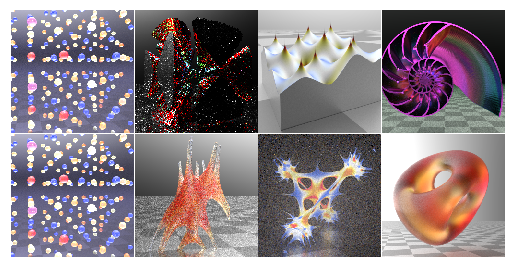

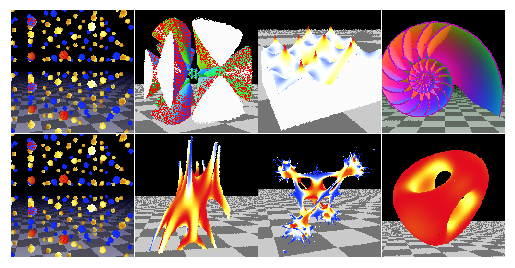

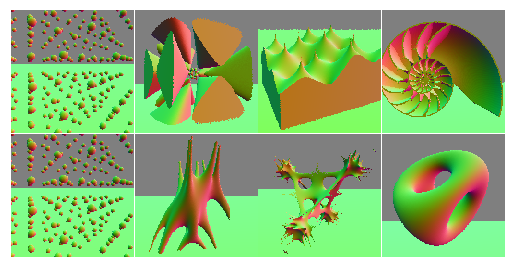

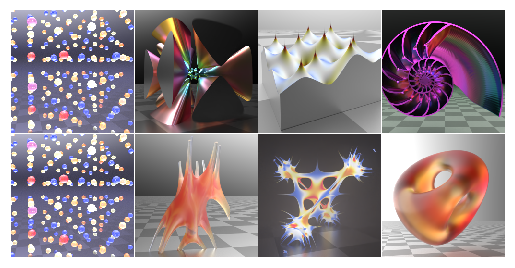

In [3]:
class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = [load_data_file(filename) for filename in os.listdir("data/")]
        s = 256
        self.n = n
        self.s = s
        self.coords = []
        for i in range(n):
            k = np.random.randint(0, len(self.data))
            x = np.random.randint(0, self.data[k]['w']-s+1)
            y = np.random.randint(0, self.data[k]['h']-s+1)
            self.coords.append((k, x, y))

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        k, x, y = self.coords[i]
        s = self.s
        n = self.data[k]['data'].shape[0]
        total = np.zeros((3, s, s), dtype=np.float32)
        weights = np.zeros((3, s, s), dtype=np.float32)
        spp = round(0.6 * np.random.random()**4 * 2**n + 0.5)
        for _ in range(n):
            if (spp >> _) & 1 == 0:
                continue
            frame = self.data[k]['data'][_, :, x:x+s, y:y+s]
            dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**_
            total += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
            weights += dw
        return [
            np.fmax(total / np.fmax(weights, 1), 0.0) ** (1.0/2.2),
            self.data[k]['aux'][:, x:x+s, y:y+s],
            np.fmax(self.data[k]['ref'][:, x:x+s, y:y+s], 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, a, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(a[:, 0:3])
plot_imgs(a[:, 3:6]*0.5+0.5)
# plot_imgs(a[:, 6:7]*0.5+0.5)
plot_imgs(y)

In [4]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True)

def conv1(nin, nout):
    return torch.nn.Conv2d(nin, nout, 1, padding=0, bias=True)

def dconv4(nin, nout):
    return torch.nn.ConvTranspose2d(nin, nout, 4, 2, 1, bias=True)

def relu(x):
    return F.relu(x, inplace=False)

def pool(x):
    return F.max_pool2d(x, 2)

def concat(a, b):
    return torch.concat((a, b), axis=1)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n0 = 12
        n1 = 16
        n2 = 24
        n3 = 32
        self.econv0a = conv3(11, n0) # 1
        self.econv0b = conv3(n0, n0) # 1
        self.econv1 = conv3(n0, n1) # 1/2
        self.econv2 = conv3(n1, n2) # 1/4
        self.mconv1 = conv3(n2, n3) # 1/8
        self.mconv2 = conv3(n3, n3) # 1/8
        self.dconv2a = dconv4(n3, n2) # 1/8->1/4
        self.dconv2b = conv3(n2+n2, n2) # 1/4
        self.dconv1a = dconv4(n2, n1) # 1/4->1/2
        self.dconv1b = conv3(n1+n1, n1) # 1/2
        self.dconv0a = dconv4(n1, n0) # 1/2->1
        self.dconv0b = conv3(n0+n0, n0) # 1
        # self.dconv0 = conv3(n0+n0, 3) # 1
        # self.dconv0 = conv3(n0, 3) # 1
        self.oconva = conv3(n0+n0, 3) # 1
        self.oconvb = conv3(n0, 3) # 1

    def forward(self, input):
        e0 = self.econv0b(relu(self.econv0a(input))) # 1
        e1 = self.econv1(pool(e0)) # 1/2
        e2 = self.econv2(pool(e1)) # 1/4
        m1 = self.mconv1(pool(e2)) # 1/8
        m2 = self.mconv2(relu(m1)) # 1/8
        d2 = relu(self.dconv2a(relu(m2))) # 1/4
        d2 = relu(self.dconv2b(concat(d2, e2))) # 1/4
        d1 = relu(self.dconv1a(d2)) # 1/2
        d1 = relu(self.dconv1b(concat(d1, e1))) # 1/2
        d0 = relu(self.dconv0a(d1)) # 1
        do = relu(self.dconv0b(concat(d0, e0))) # 1
        # return self.dconv0(do)
        # return self.dconv0b(concat(d0, e0))
        return self.oconva(concat(d0, e0)) + self.oconvb(do)


model = Model().to(device)
print(model)

Model(
  (econv0a): Conv2d(11, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0b): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mconv1): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mconv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv2a): ConvTranspose2d(32, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv2b): Conv2d(48, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv1a): ConvTranspose2d(24, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv1b): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv0a): ConvTranspose2d(16, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv0b): Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (oconva): Conv2d(24,

128 0.04001874849200249
256 0.03837104141712189
384 0.015310980379581451
512 0.015421584248542786
640 0.030528977513313293
768 0.011587148532271385
896 0.04121249169111252
1024 0.02028815634548664
1152 0.06602825969457626
1280 0.06168658286333084
1408 0.034905657172203064
1536 0.012512425892055035
1664 0.026751434430480003
1792 0.019947361201047897
1920 0.016479982063174248
2048 0.01405890192836523
2176 0.017748665064573288
2304 0.03759734332561493
2432 0.009165830910205841
2560 0.014883933588862419
2688 0.01927562616765499
2816 0.008794109337031841
2944 0.021559350192546844
3072 0.0212472602725029
3200 0.014458183199167252
3328 0.03124849498271942
3456 0.0109180873259902
3584 0.016952838748693466
3712 0.013131111860275269
3840 0.012293495237827301
3968 0.010785932652652264
4096 0.011621391400694847


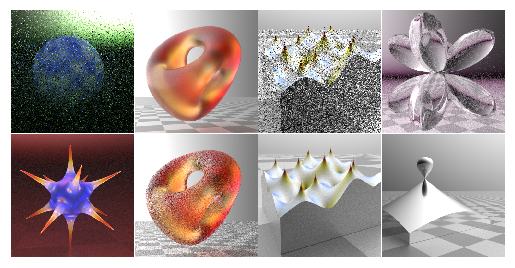

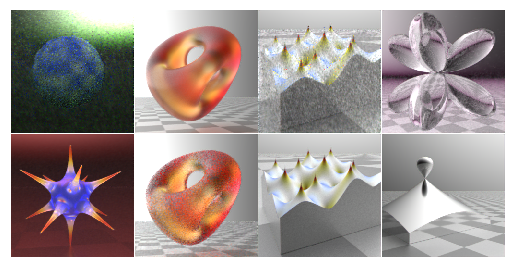

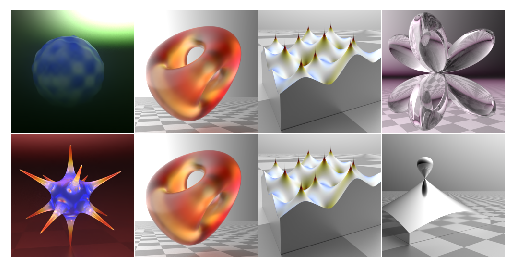

4224 0.006628519855439663
4352 0.014658293686807156
4480 0.016054613515734673
4608 0.005451925098896027
4736 0.00835596676915884
4864 0.020556244999170303
4992 0.005426862742751837
5120 0.013331158086657524
5248 0.006706455256789923
5376 0.01677369698882103
5504 0.005564277525991201
5632 0.015403795056045055
5760 0.010938478633761406
5888 0.008710809051990509
6016 0.010814746841788292
6144 0.008724438026547432
6272 0.01338716596364975
6400 0.020321816205978394
6528 0.011292552575469017
6656 0.012801642529666424
6784 0.02050475776195526
6912 0.012063468806445599
7040 0.004897403996437788
7168 0.015585565939545631
7296 0.013346157968044281
7424 0.017485860735177994
7552 0.021320423111319542
7680 0.02066943608224392
7808 0.013625577092170715
7936 0.008570884354412556
8064 0.01215455960482359
8192 0.008302826434373856


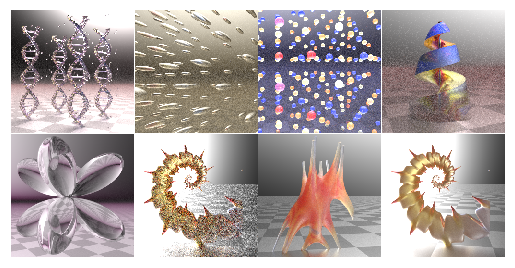

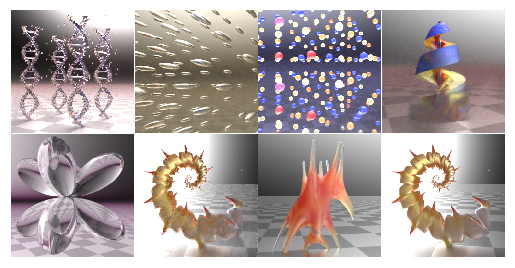

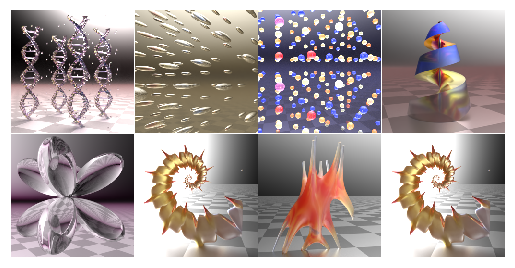

8320 0.010632060468196869
8448 0.017009805887937546
8576 0.006141049321740866
8704 0.00565912714228034
8832 0.012660481035709381
8960 0.0063917371444404125
9088 0.010657202452421188
9216 0.018556848168373108
9344 0.007072481792420149
9472 0.008472639136016369
9600 0.0070500001311302185
9728 0.01485896110534668
9856 0.010993195697665215
9984 0.005692215170711279
10112 0.012308190576732159
10240 0.009272193536162376
10368 0.01238303817808628
10496 0.010520588606595993
10624 0.005116316955536604
10752 0.0070792450569570065
10880 0.01536818128079176
11008 0.013596875593066216
11136 0.02203541062772274
11264 0.007129494100809097
11392 0.014308614656329155
11520 0.010366243310272694
11648 0.007177665829658508
11776 0.009801195934414864
11904 0.007325565442442894
12032 0.009071450680494308
12160 0.009924046695232391
12288 0.014601591974496841


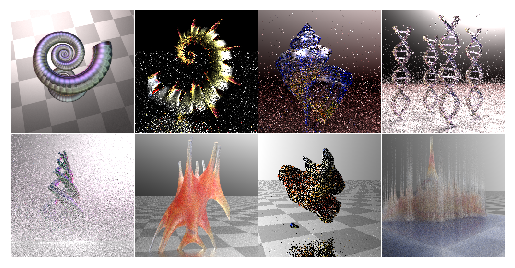

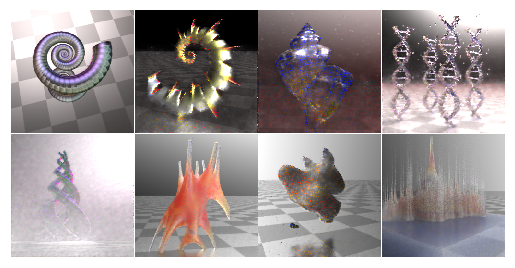

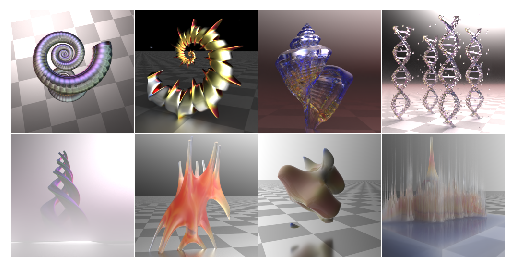

12416 0.004859852604568005
12544 0.014919697307050228
12672 0.010111885145306587
12800 0.007009274326264858
12928 0.016473308205604553
13056 0.00702559482306242
13184 0.009209578856825829
13312 0.009870531968772411
13440 0.009955031797289848
13568 0.007520341780036688
13696 0.006399692501872778
13824 0.00824100710451603
13952 0.0038338499143719673
14080 0.0053510344587266445
14208 0.009851456619799137
14336 0.00844382494688034
14464 0.010877557098865509
14592 0.014550100080668926
14720 0.015393171459436417
14848 0.010295212268829346
14976 0.00992435310035944
15104 0.011151289567351341
15232 0.01930791698396206
15360 0.018616272136569023
15488 0.00935615785419941
15616 0.02019895613193512
15744 0.021942056715488434
15872 0.006510278210043907
16000 0.013292737305164337
16128 0.01068198960274458
16256 0.010122507810592651
16384 0.013932572677731514


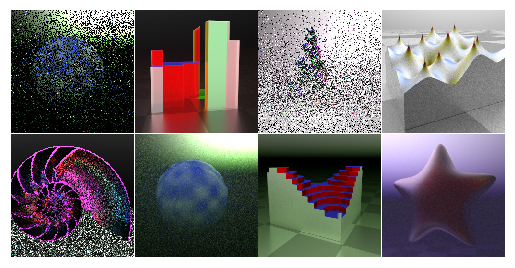

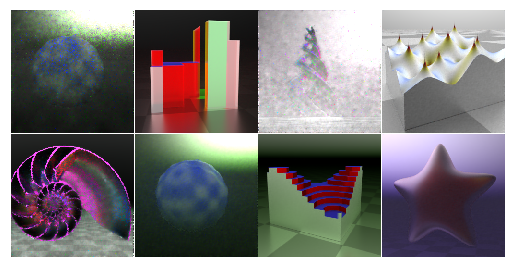

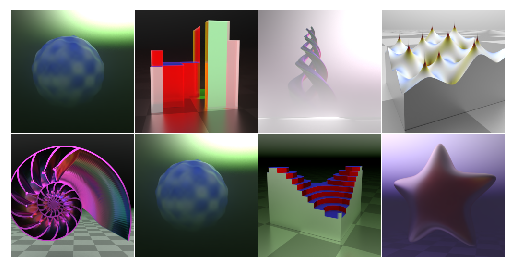

16512 0.013469533994793892
16640 0.0047482214868068695
16768 0.0162971131503582
16896 0.009655032306909561
17024 0.019704513251781464
17152 0.018154770135879517
17280 0.005352163687348366
17408 0.009417282417416573
17536 0.009266503155231476
17664 0.009895875118672848
17792 0.006161333527415991
17920 0.00896139070391655
18048 0.013182736933231354
18176 0.010829098522663116
18304 0.017071325331926346
18432 0.010138547979295254
18560 0.011848360300064087
18688 0.00468484265729785
18816 0.011063741520047188
18944 0.01066046953201294
19072 0.009969593957066536
19200 0.012179452925920486
19328 0.005359848029911518
19456 0.008509144186973572
19584 0.010225476697087288
19712 0.015401527285575867
19840 0.017300216481089592
19968 0.02388657256960869
20096 0.012347246520221233
20224 0.00915720034390688
20352 0.008917491883039474
20480 0.013998779468238354


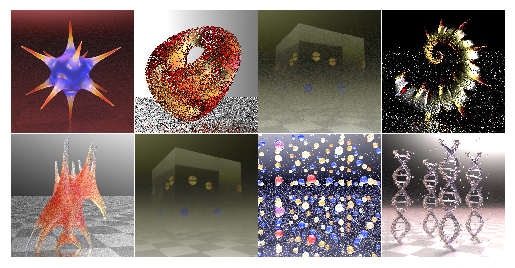

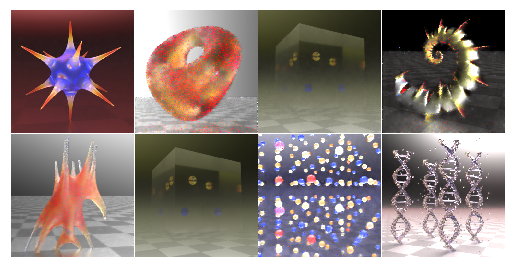

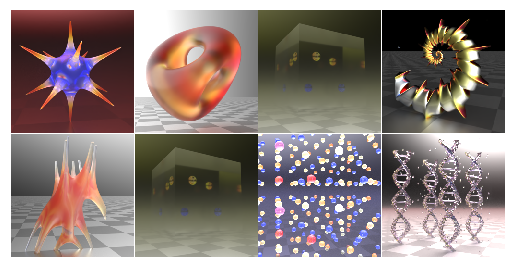

20608 0.007778951432555914
20736 0.011812036857008934
20864 0.008868771605193615
20992 0.007619133219122887
21120 0.007731106132268906
21248 0.009500335901975632
21376 0.00793854333460331
21504 0.015950269997119904
21632 0.013207023963332176
21760 0.006755414418876171
21888 0.008417053148150444
22016 0.020021917298436165
22144 0.017842089757323265
22272 0.013776826672255993
22400 0.011743186973035336
22528 0.013375824317336082
22656 0.008871310390532017
22784 0.00735160056501627
22912 0.006417793687433004
23040 0.00589556572958827
23168 0.015467457473278046
23296 0.011057913303375244
23424 0.011380075477063656
23552 0.010820372961461544
23680 0.02235923521220684
23808 0.006085291039198637
23936 0.006391108967363834
24064 0.01707133650779724
24192 0.008114534430205822
24320 0.014961585402488708
24448 0.012424444779753685
24576 0.02112710475921631


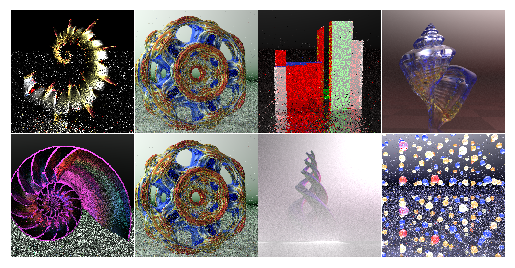

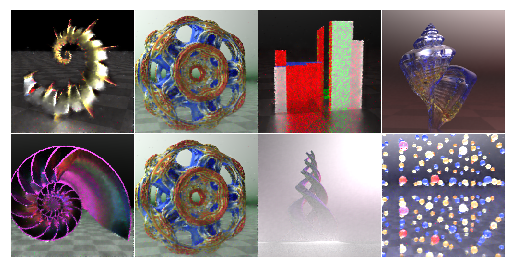

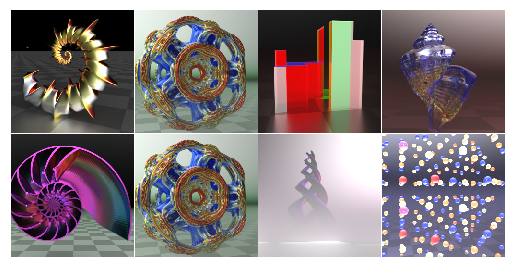

24704 0.006719765719026327
24832 0.014274494722485542
24960 0.006028778851032257
25088 0.008457938209176064
25216 0.008528109639883041
25344 0.007612257730215788
25472 0.010095097124576569
25600 0.011935587041079998
25728 0.01074623130261898
25856 0.01017377432435751
25984 0.00983369443565607
26112 0.011957640759646893
26240 0.006927670910954475
26368 0.010233083739876747
26496 0.008794786408543587
26624 0.01969890110194683
26752 0.012405077926814556
26880 0.008387069217860699
27008 0.011150136590003967
27136 0.004803916439414024
27264 0.01460951566696167
27392 0.00600867485627532
27520 0.009107517078518867
27648 0.005900440737605095
27776 0.009421085938811302
27904 0.011117177084088326
28032 0.009371217340230942
28160 0.009031234309077263
28288 0.014233812689781189
28416 0.009647892788052559
28544 0.00822373665869236
28672 0.016592547297477722


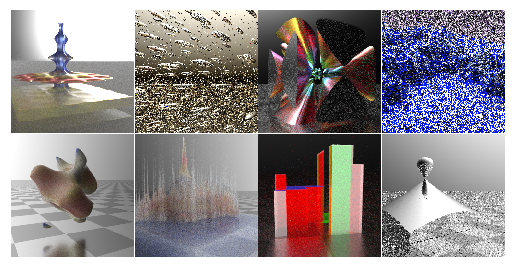

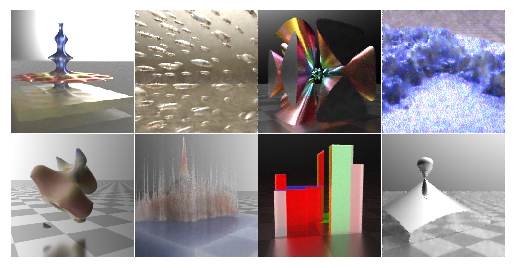

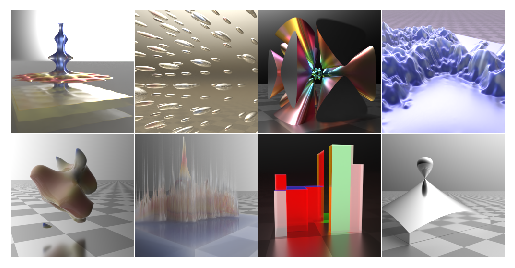

28800 0.00819495227187872
28928 0.004076614044606686
29056 0.010537644848227501
29184 0.007949266582727432
29312 0.007456490304321051
29440 0.010396819561719894
29568 0.01203883346170187
29696 0.010468157939612865
29824 0.005873478949069977
29952 0.005433210637420416
30080 0.014513364061713219
30208 0.00557248480618
30336 0.015188878402113914
30464 0.006993742659687996
30592 0.01715441793203354
30720 0.011456191539764404
30848 0.005906888283789158
30976 0.00919035729020834
31104 0.007219887804239988
31232 0.01130340900272131
31360 0.007926825433969498
31488 0.0147952726110816
31616 0.010910349898040295
31744 0.013129672035574913
31872 0.007304126396775246
32000 0.010035939514636993
32128 0.0134690310806036
32256 0.006702766753733158
32384 0.010472162626683712
32512 0.008660230785608292
32640 0.010810690931975842
32768 0.0052146390080451965


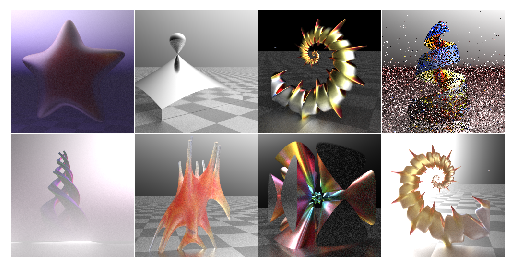

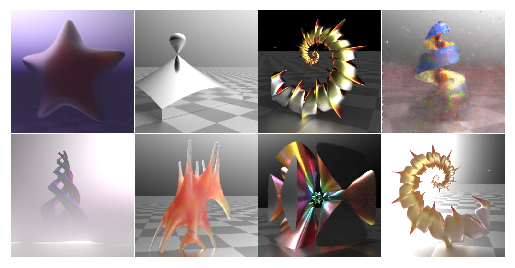

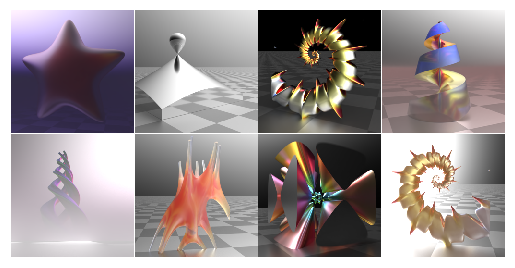

In [5]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001
    # lr = 0.00001
)

def color_norm(c):
    return (c[:,0:1]**2 + c[:,1:2]**2 + c[:,2:3]**2) ** 0.5

def lossfun(output, reference):
    return torch.mean(torch.abs(output-reference))

model_params = torch.cat([x.view(-1) for x in model.parameters()])

batch_count = 0
for epoch in range(2):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(2**17), batch_size=8, shuffle=True)
    for x, a, y in trainloader:
        x = x.to(device)
        a = a.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)
        # x = torch.pow(x, 2.2)
        # y = torch.pow(y, 2.2)
        optimizer.zero_grad()
        m_in = torch.concatenate((
            a[:,0:3], color_norm(a[:,0:3]), # albedo
            a[:,3:6], a[:,3:4]**2+a[:,4:5]**2,  # normal
            x,  # pixels
            ), axis=1)
        output = model(m_in)
        torch.mean(torch.abs(output))
        loss = lossfun(output, y-x)
        # regl1 = 0.1 * torch.mean(torch.abs(model_params))
        # regl2 = 0.1 * torch.mean(torch.abs(model_params))
        # (loss+regl1+regl2).backward()
        loss.backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 128 == 0:
            print(batch_count, loss.item())
        if batch_count % 4096 == 0:
            plot_imgs(torch.exp(x)-1)
            plot_imgs(torch.exp((output+x).detach())-1)
            plot_imgs(torch.exp(y)-1)
            # plot_imgs(torch.pow(x, 1.0/2.2))
            # plot_imgs(torch.pow(torch.clip(output+x,0.0,1.0).detach(), 1.0/2.2))
            # plot_imgs(torch.pow(y, 1.0/2.2))


In [6]:
torch.save(model, "model4anc_small.pth")